In [1]:
import pandas as pd
import numpy as np

def readDF(name):
    df = pd.read_csv('Data/SlicedData/' + name + '.csv')
    df = df.rename(columns = {'Unnamed: 0' : 'Index'})
    df = df.set_index('Index', drop = True)
    return df

df1 = readDF('df1')
df2 = readDF('df2')
df3 = readDF('df3')
df4 = readDF('df4')

returnTime = lambda df: np.linspace(0, len(df) / 2 - 0.5, len(df))
time1 = returnTime(df1)
time2 = returnTime(df2)
time3 = returnTime(df3)
time4 = returnTime(df4)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

mpl.rc('font', family = 'Times New Roman')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# sc = MinMaxScaler()

def sliding_windows(train_df, test_df, axis, seq_length):
    x, y = [], []
    for data in train_df:
        data = data.iloc[:, axis:axis + 3].values
#         data = sc.fit_transform(data)
        for i in range(len(data) - seq_length - 1):
            _x = data[i:(i + seq_length)]
            _y = data[i + seq_length]
            x.append(_x)
            y.append(_y)
    x, y = np.array(x), np.array(y)
    trainX, trainY = Variable(torch.Tensor(np.array(x))), Variable(torch.Tensor(np.array(y)))
    x, y = [], []
    for data in test_df:
        data = data.iloc[:, axis:axis + 3].values
#         data = sc.fit_transform(data)
        for i in range(len(data) - seq_length - 1):
            _x = data[i:(i + seq_length)]
            _y = data[i + seq_length]
            x.append(_x)
            y.append(_y)
    x, y = np.array(x), np.array(y)
    testX, testY = Variable(torch.Tensor(np.array(x))), Variable(torch.Tensor(np.array(y)))
    return trainX.to(device), trainY.to(device), testX.to(device), testY.to(device)
    
seq_length = 3
train_df = [df3, df4]
test_df = [df1, df2]
'''
0: X
1: Y
2: Z
'''
trainX, trainY, testX, testY = sliding_windows(train_df, test_df, 0, seq_length)

In [4]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)        
        out = self.fc(h_out)
        return out

In [5]:
num_epochs = 2000
learning_rate = 0.01

input_size = 3
hidden_size = 1000
num_layers = 1
num_classes = 3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 35.89135
Epoch: 100, loss: 1.70159
Epoch: 200, loss: 1.25856
Epoch: 300, loss: 0.92198
Epoch: 400, loss: 1.09931
Epoch: 500, loss: 0.39386
Epoch: 600, loss: 0.25728
Epoch: 700, loss: 0.21070
Epoch: 800, loss: 0.14033
Epoch: 900, loss: 0.06375
Epoch: 1000, loss: 0.04986
Epoch: 1100, loss: 0.02608
Epoch: 1200, loss: 0.01713
Epoch: 1300, loss: 0.02626
Epoch: 1400, loss: 0.01463
Epoch: 1500, loss: 0.01978
Epoch: 1600, loss: 0.04200
Epoch: 1700, loss: 0.00367
Epoch: 1800, loss: 0.01351
Epoch: 1900, loss: 0.00844


In [6]:
lstm.eval()

def plotResult(dataX, dataY):
    predY = lstm(dataX)
    predY = predY.data.cpu().numpy()
    dataY = dataY.data.cpu().numpy()
#     predY = sc.inverse_transform(predY)
#     dataY = sc.inverse_transform(dataY)
    plt.figure(figsize = (10, 10))
    for i in range(3):
        plt.subplot(3, 1, i + 1)
        t = returnTime(dataX)
        plt.plot(t, dataY[:, i], 'b', linewidth = 1)
        plt.plot(t, predY[:, i], 'r', linewidth = 1)
        plt.legend({'Actual', 'Prediction'})
    #     plt.suptitle('Time-Series Prediction')
        plt.xlabel('Time [sec]')
        plt.ylabel('Acceleration [m/$s^2$]')
        plt.ylim([-20, 20])
        plt.grid()
        print(max(abs(dataY[:, i] - predY[:, i])))
    plt.show()

2.8997903
1.9274945
1.8702536


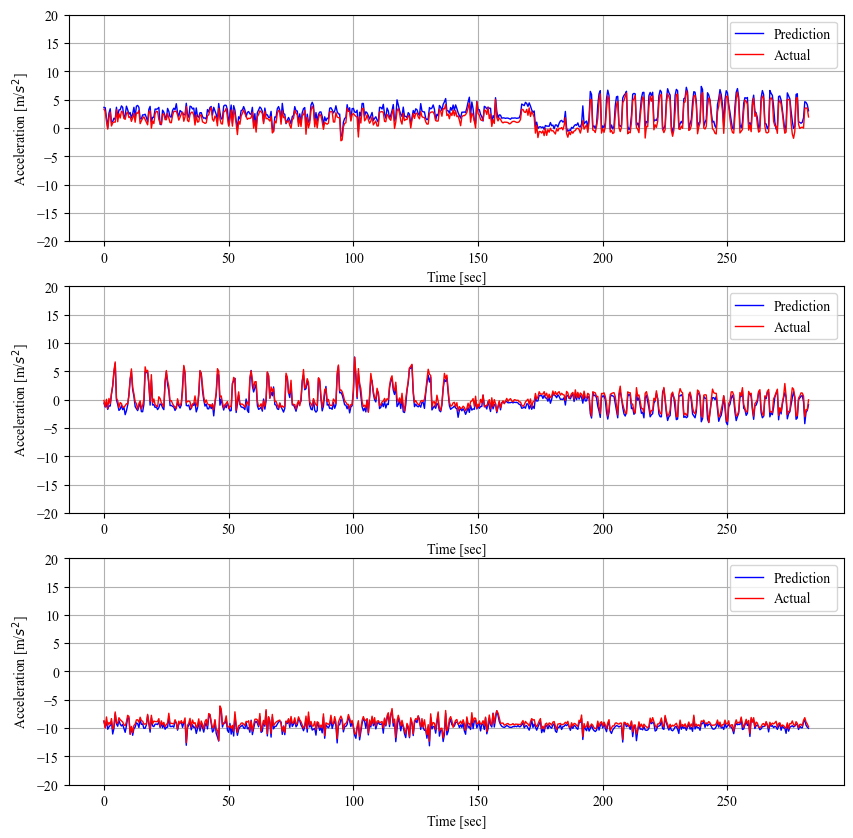

In [7]:
plotResult(trainX, trainY)

7.075634
7.965597
5.041379


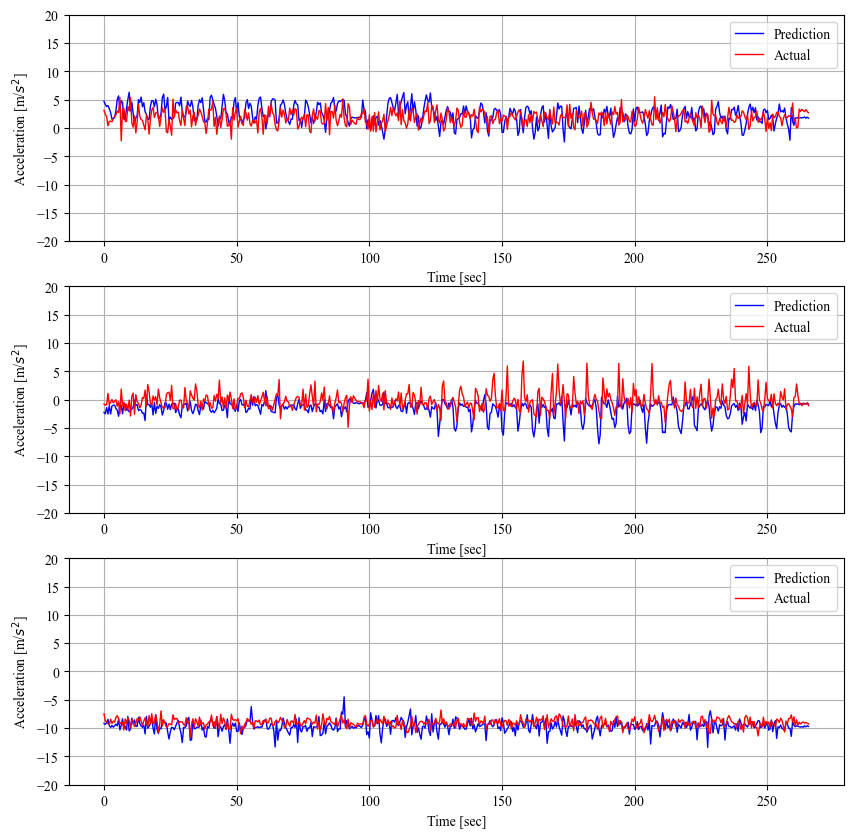

In [8]:
plotResult(testX, testY)

15.506787
11.7663
9.419213


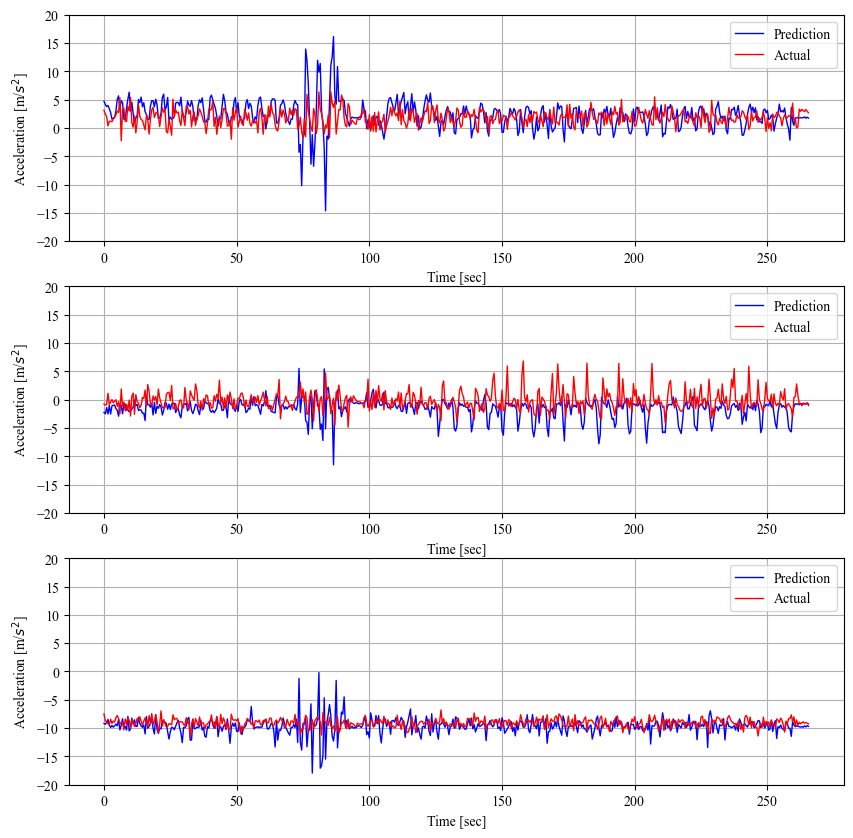

In [9]:
import copy

test_df_shock = copy.deepcopy(test_df)
test_df_shock[0][150:180] = (test_df[0][150:180] - np.mean(test_df[0][150:180])) * 5 + np.mean(test_df[0][150:180])
_, _, testX_shock, testY_shock = sliding_windows(train_df, test_df_shock, 0, seq_length)
plotResult(testX_shock, testY_shock)